In [1]:
import pandas as pd
import joblib
from scipy import stats
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from datasets import dataset_list, get_sg_groups_df
from core import (get_predictive_performance,
                  setup_plots,
                  plot_spearman_heatmap,
                  plot_model_performance,
                  get_tidy_cv_df,
                  get_feature_df)

In [2]:
def get_fold_predictions(fold, fold_df, model_name, indel_predictions,
                         base_model=Pipeline([('imputer', SimpleImputer(strategy='median')),
                                              ('regressor', LGBMRegressor(random_state=7, n_jobs=8))])):
    """Get predictions for a given fold

    :param fold: int
    :param fold_df: DataFrame
    :param model_name: str
    :param base_model: Pipeline(Imputer, Regressor)
    :return: DataFrame, test predictions
    """
    train_df = fold_df.query('train == True').reset_index(drop=True)
    train_feature_df = train_df.merge(indel_predictions, how='inner',
                                      on='sgRNA Context Sequence')
    X_train = train_feature_df[indel_predictions.columns].drop('sgRNA Context Sequence', axis=1)
    y_train = train_df['Residual Activity']
    test_df = fold_df.query('train == False').reset_index(drop=True)
    test_feature_df = test_df.merge(indel_predictions, how='inner',
                                    on='sgRNA Context Sequence')
    X_test = test_feature_df[indel_predictions.columns].drop('sgRNA Context Sequence', axis=1)
    model = clone(base_model)
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions

In [3]:
setup_plots()

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
indelphi_predictions = pd.read_csv('../data/external/indelphi_rs_dev.csv')
seq_model = joblib.load('../models/RuleSet3.pkl')

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        if ds.endogenous:
            train_data_list.append(ds)


sg_groups_df = get_sg_groups_df(train_data_list)

Context sequences with multiple targets: 0


In [6]:
sg_df_residuals = sg_groups_df.copy()
seq_X = get_feature_df(sg_df_residuals)
sg_df_residuals['Rule Set 3'] = seq_model.predict(seq_X)
(sg_df_residuals.groupby('dataset')
 .apply(lambda df: stats.pearsonr(df['Rule Set 3'], df['sgRNA Activity'])))


dataset
Doench2014_human     (0.7808375117208222, 4.324227242326856e-205)
Doench2014_mouse     (0.7404292413640493, 1.379605215185353e-203)
Doench2016                              (0.6937302010352973, 0.0)
Munoz2016                               (0.7588083762083931, 0.0)
Wang2014            (0.7817756947398344, 1.9046619919131385e-211)
dtype: object

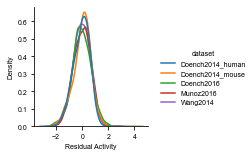

In [7]:
sg_df_residuals['Residual Activity'] = sg_df_residuals['sgRNA Activity'] - sg_df_residuals['Rule Set 3']
sns.displot(data=sg_df_residuals, x='Residual Activity', hue='dataset',
            kind='kde', common_norm=False, height=2.2)

## Cross Validation iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [8]:
tidy_cv_df = get_tidy_cv_df(sg_df_residuals, random_state=1)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n')
 .sort_values(['n', 'cv', 'dataset']))

,cv,dataset,n
23,2,Doench2014_human,1
22,2,Doench2014_mouse,1
24,4,Doench2014_human,1
0,0,Doench2014_human,2
1,0,Doench2014_mouse,2
20,0,Doench2016,2
19,0,Munoz2016,2
18,0,Wang2014,2
17,1,Doench2014_human,2
16,1,Doench2014_mouse,2


- Training sizes vary from 18,677 - 22,586 sgRNAs
- Testing sizes vary from 4,272 - 8,181 sgRNAs

In [9]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
9,0,False,4272
0,0,True,22586
5,1,False,8181
4,1,True,18677
8,2,False,4372
1,2,True,22486
6,3,False,5544
3,3,True,21314
7,4,False,4489
2,4,True,22369


As expected each gene target (gene) only appears in one set in each fold

In [10]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 [['cv', 'target']].value_counts()  # will show up twice if train == False and True
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Testing Indel Frequencies


In [11]:
clean_indel_predictions = (indelphi_predictions.rename({'ID': 'sgRNA Context Sequence'}, axis=1)
                           .drop(['Target', 'PAM Index'], axis=1))

In [12]:
prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    predictions = get_fold_predictions(fold, df, model_name='Indel Predictions',
                                       indel_predictions=clean_indel_predictions)
    prediction_list.append(predictions)

predictive_performance, agg_performance = get_predictive_performance(prediction_list, 'Residual Activity')

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


In [14]:
agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,Indel Predictions,0.013325,0.0555,0.019415


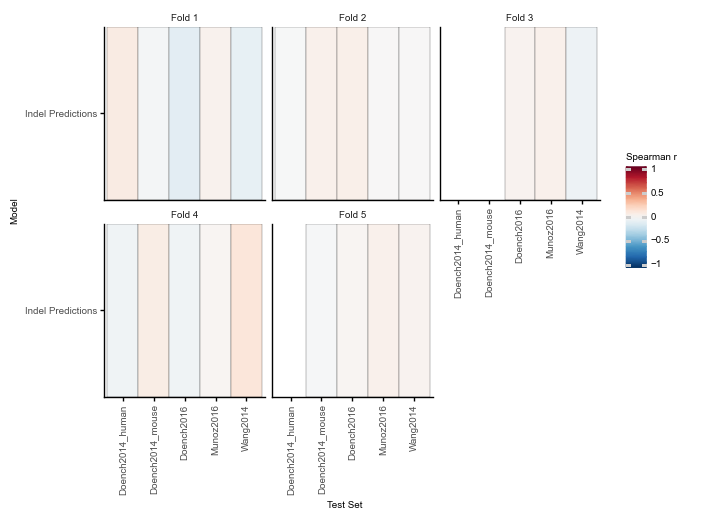

<ggplot: (8778834267606)>

In [15]:
plot_spearman_heatmap(predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You passed a edgecolor/edgecolors (['#000000ff']) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/geoms/geom_point.py:61: UserWarning: You pa

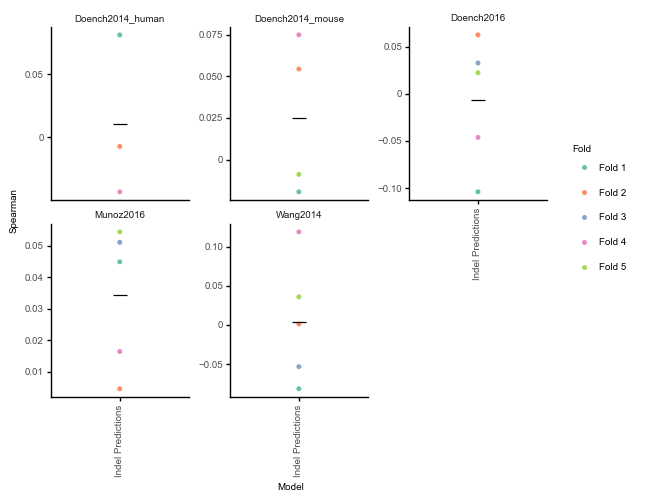

<ggplot: (8778895373906)>

In [16]:
plot_model_performance(predictive_performance)